In [11]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy as sp
import sys

sys.path.append(r'C:\Users\danie\Documents\Random Quantum Circuits\Amos efficient code')

from Lib_gen import *

In [12]:
def TwoGateRanPhase_parity(q,eps): #defining the two site gate with random phases on the diagonal
    """eps = Standard deviation """
    ranphases = np.random.normal(0, eps, q*q)
    #ranphases = 2*np.pi*np.random.rand(q*q)
    diagonals = np.zeros((q**2,q**2),dtype='complex')
    for b in range(q):
        for a in range(q-1):
            if b>a:
                ranphase=ranphases[0]
                diagonals[a*q+b][a*q+b]=np.exp(1j *ranphase)
                diagonals[b*q+a][b*q+a]=np.exp(1j *ranphase)
            if a==b:
                ranphase=ranphases[0]
                diagonals[a*q+b][a*q+b]=np.exp(1j *ranphase)
            ranphases=np.delete(ranphases,[0])
    diagonals[q**2-1][q**2-1]=np.exp(1j *ranphases[0])
    return diagonals#

def OneGateCUE_parity(q,eps): #defining the one site gate with random phases on the diagonal
    ranphases = np.random.normal(0, eps, q)
    diagonals = np.array([[numpy.exp(1j *ranphases[i]) for i in range(0,q)]])
    return scipy.sparse.diags(diagonals, [0])

In [13]:
def qSwap(q):
    A=np.zeros((q**2,q**2))
    A[q**2-1][q**2-1]=1
    
    for b in range(q):
        for a in range(q-1):
            if b>a:
                A[a*q+b][b*q+a]=1
                A[b*q+a][a*q+b]=1
            if a==b:
                A[a*q+b][b*q+a]=1
    return A

In [34]:
def W_cue_random_phase_parity(q,L,eps,list=True):
    if L%2==0:
        twogates= [TwoGateRanPhase(q,eps) for i in range(int(L/2-1))]
        
        ### Random Phase
        biglist1=[Sparse2gate_general_multiarg_given_mat(twogates[i-1],q,L,i) for i in range(1,int(L/2))]
        biglist1.append(Sparse2gate_general_multiarg_given_mat(TwoGateRanPhase_parity(q,eps),q,L,int(L/2)))
        for i in range(int(L/2)+1,L):
            A = sparse.csr_matrix.dot(qSwap(q),twogates[L-1-i]) 
            A = sparse.csr_matrix.dot(A,qSwap(q))
            
            biglist1.append(Sparse2gate_general_multiarg_given_mat(A,q,L,i))
        
        ### CUE 1gates:
        onegates = [cue(q) for i in range(int(L/2))]
        biglist2=[Sparse1gate_general_multiarg_given_mat(onegates[i-1],q,L,i) for i in range(1,int(L/2)+1)]
        biglist2=biglist2+[Sparse1gate_general_multiarg_given_mat(onegates[L-i],q,L,i) for i in range(int(L/2)+1,L+1)]
    else:
        twogates= [TwoGateRanPhase(q,eps) for i in range(int((L-1)/2))]
        
        ### Random Phase
        biglist1=[Sparse2gate_general_multiarg_given_mat(twogates[i-1],q,L,i) for i in range(1,int((L-1)/2+1))]
        for i in range(int((L-1)/2+1),L):
            A = sparse.csr_matrix.dot(qSwap(q),twogates[L-1-i]) 
            A = sparse.csr_matrix.dot(A,qSwap(q))
            
            biglist1.append(Sparse2gate_general_multiarg_given_mat(A,q,L,i))
        
        ### CUE 1gates:
        onegates = [cue(q) for i in range(int((L-1)/2))]
        biglist2=[Sparse1gate_general_multiarg_given_mat(onegates[i-1],q,L,i) for i in range(1,int((L-1)/2+1))]
        biglist2.append(Sparse1gate_general_multiarg_given_mat(cue(q),q,L,int((L-1)/2+1)))
        biglist2=biglist2+[Sparse1gate_general_multiarg_given_mat(onegates[L-i],q,L,i) for i in range(int((L+3)/2)+1,L+1)]        
    
    if(list): #if list is True, returns just the list, otherwise the corresponding multiplied matrix
        return biglist1+biglist2

    else:

        temp = biglist2[0]
        for (i,mat) in enumerate(biglist2):
            if not(i==0):
                temp = mat.dot(temp)
            else:
                pass
        for (j,mat) in enumerate(biglist1):
            temp = mat.dot(temp)
        return temp.todense()

In [40]:
def W_cue_random_phase_parity_temporally_random(q,L,eps,circuit=0):
    New_layer = W_cue_random_phase_parity(q,L,eps,list=False)
    if type(circuit) is int:
        return New_layer
    else:
        return New_layer.dot(circuit)                               

In [43]:
# Define the system parameters
L = 6  # System size
q = 3   # Quantum dimension
tmax = 400  # Maximum time
freq = 1   # Time step frequency
repeat=100
eps=0.5
# Generate the quantum circuit

# Initialize time and SFF arrays
times = np.arange(0, tmax, freq)
sff_values_rpm_parity = np.zeros(len(times))

# Calculate SFF at each time step
for _ in range(repeat):
    for t in times:    
        if t==0:
            circuit = W_cue_random_phase_parity(q,L,eps,list=False)
        else:
            circuit = W_cue_random_phase_parity_temporally_random(q,L,eps,circuit=circuit)
        sff_values_rpm_parity[t-1]+=np.linalg.norm(np.trace(circuit))/repeat
    if _%50==0:
        print('Done 50')

Done 50
Done 50


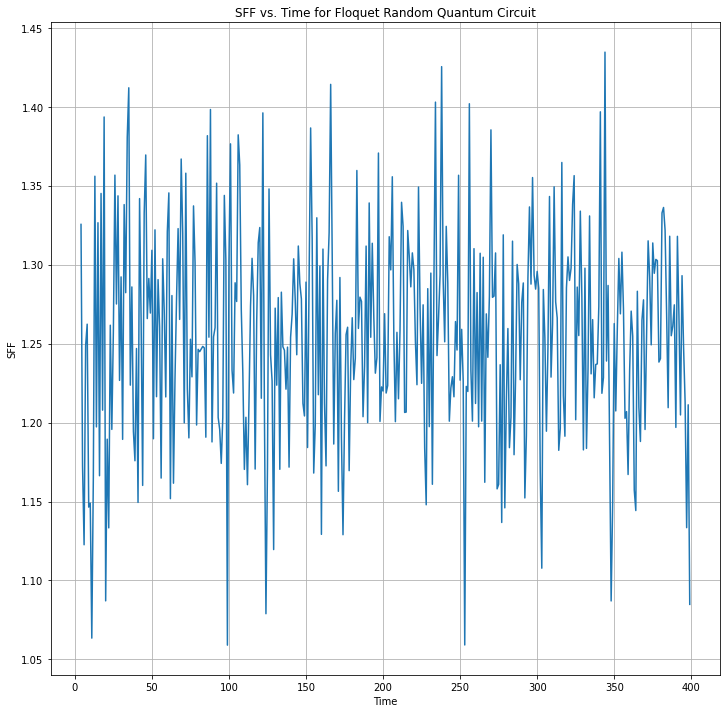

In [44]:
fig=plt.figure(figsize=(12,12))
plt.plot(times[4:], sff_values_rpm_parity[4:])

#f,residuals,_,_,_ = np.polyfit(np.log(times[1:]), sff_values_rpm_parity[1:], 1,full=True)
#plt.plot(times[1:],(f[0]*np.log(times[1:])+f[1]))

plt.xlabel('Time')
plt.ylabel('SFF')
plt.title('SFF vs. Time for Floquet Random Quantum Circuit')
plt.grid(True)
plt.show()

#print(f[0],f[1])